# Cloning

In [1]:
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/CompVis/taming-transformers.git

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 6.37 MiB/s, done.
Resolving deltas: 100% (140/140), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340 (from 1)
Receiving objects: 100% (1342/1342), 409.77 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (282/282), done.


# Loading Libraries

In [2]:
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 32.3 MB/s eta 0:00:00


# Importing Libraries

In [3]:
import numpy as np
import torch
import os
import imageio, pdb, math
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import yaml #markup language that is used by one of these architectures
from omegaconf import OmegaConf

from CLIP import clip

# Helper Functions

In [4]:
def show_from_tensor(tensor):
  """
  we will be evolving the values of that generated image that will be in tensor format sometimes
  we want to display it. We want to show an image from a tensor
  """
  # get information on a seperate part of our memory, on a seperate variable
  img = tensor.clone()
  # information in that tensor is gonna be on a range that is gonna be more or less between 0-1. We
  # want to displaying it from 0-255 range. Cast it with as a byte
  img = img.mul(255).byte()
  # to display it we need to convert
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show() # this is the function taking a tensor and display as an image

def normalize_data(data):
  return (data.clip(-1,1)+1)/2
  #range between 0 and 1 in the result


# Parameters

In [5]:
lr = 0.5
# batch size for we are going to work in one single image
BATCH_SIZE = 1
# Regularized parameter. Is gonna be used internally by the optimizer. Help optimizer
# limit the size of the weights to improve generalization capabilities of the architecture
wd = 0.1
# we're gonna be creating some crops of the image that we're generating. We're gonna resize those
# crops and this noise factor will improve all the optimization process
noise_factor = 0.1

total_iteration = 200
# the result we want to obtain, what is the size of that result we want (h,w,c)
image_shape = [225, 400, 3]

size1, size2, channels = image_shape

# CLIP Model

In [7]:
clipmodel, _ = clip.load("ViT-B/32", jit = False)
# clip can use internally different architecture we are going to use visually transformer
# one "ViT-B/32"

clipmodel.eval()
# eval mode. CLIP is already trained, do not train it. We want to do inference with it.
# We want something through it
print(clip.available_models())

print("CLIP model visual input resolution: ", clipmodel.visual.input_resolution)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Make sure memory of the GPU cache empty
torch.cuda.empty_cache()
"""
the CLIP library is downloading its pretrained model. So we do not need to train CLIP, and
we can proceed to use it in inference, eval mode to encode texts and images directly

From downloading information [ ] things inside that brackets are architectures of CLIP can use
internally. RN50(RestNet with 50 layers)

224 pixels. When we encode images in CLIP, we need to set them to 224 pixels.
"""

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
CLIP model visual input resolution:  224


'\nthe CLIP library is downloading its pretrained model. So we do not need to train CLIP, and\nwe can proceed to use it in inference, eval mode to encode texts and images directly\n\nFrom downloading information [ ] things inside that brackets are architectures of CLIP can use\ninternally. RN50(RestNet with 50 layers)\n\n224 pixels. When we encode images in CLIP, we need to set them to 224 pixels.\n'

# Taming Transformer Instantiation

Enter inside the folder where the taming transformer is. We need to download the pre-trained checkpoints of the taming transformers. We do not need to train it.

* We are gonna create a folder called MODELS. Then VQGAN is actual internal architecture used in that taming transformer. _imagenet because it is being trained with images from the IMAGENET dataset.

* _f16 because it is using a downsampling factor of f16 for each. "_16384" that is the code book dimensionality. Because this type of transformer, instead of just working with raw pixels of images to build a sequence, first of all it is gonna use patches, it uses patches 16x16 pixels. It works with patches and then it builds a code book. Intead of referring directly to the batches, it is gonna build this type of data structure that is a code book, that is gonna learn to relate basically to connect parts of that code book. Parts of that code book with the result.

* /checkpoints we are gonna store checkpoints in here.

* anorther folder (second) for configuration.



In [8]:
%cd taming-transformers/

/content/taming-transformers


In [9]:
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


--2024-10-13 15:17:34--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/8be0a79a-4fe6-425e-a0aa-0f654f10da09/last.ckpt [following]
--2024-10-13 15:17:36--  https://heibox.uni-heidelberg.de/seafhttp/files/8be0a79a-4fe6-425e-a0aa-0f654f10da09/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  9.71MB/s    in 1m 40s  

2024-10-13 15:19:16 (9.37 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980092370]

--2024-10-13 15:19:1

In [11]:
from taming.models.vqgan import VQModel

def load_config(config_path, display = False):
  config_data = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config_data)))
  return config_data

def load_vqgan(config, checkpoint_path = None):
  model = VQModel(**config.model.params)
  if checkpoint_path is not None:
    state_dict = torch.load(checkpoint_path, map_location = "cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict = False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  # when we generate something new with this model we have to go two stages
  # it has one stage that is a convolutional network and another stage that is actual decoder
  x = taming_model.decoder(x) # decoder of the transformer
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display = True)
taming_model = load_vqgan(taming_config, checkpoint_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)

model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.2MB/s]


8.19kB [00:00, 549kB/s]                    
/content/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dic

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


# Declaring the values that we are going to optimize

In [12]:
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters,self).__init__()
    self.data = 0.5*torch.randn(BATCH_SIZE, 256, size1//16, size2//16).cuda()
    # 1x256x14x25 (225/16, 400/16)
    # initializing values which is random and .5 for good to do initialize values taking them normal dist
    self.data = torch.nn.Parameter(torch.sin(self.data))
    """
     this is very often done transformer architectures in these architectures comparison with recurrent
     neural networks, they have clear indication of the positioning of the elements based on architecture itself.
     Transformer architecture we just push all the data at once what is usefull to do and what is often done is to use a
     periodic mathematical function to kind of embed positioning information within the data. We're using a mathematical
     sine repeats periodically it gives different results for different parts of location of the data. When we apply
     to our data, we are basically going to embed within that data some extra information that relates to the position
     of each element. And put all of that nn.Parameter that is gonna declare these values as values that
     we will be able to optimize and work with.

    """
  def forward(self):
    return self.data

def init_params():
  # when we want to restart, reset parameters. New optimization
  params = Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr' : lr}], weight_decay = wd)
  return params, optimizer

# Encoding Prompts

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


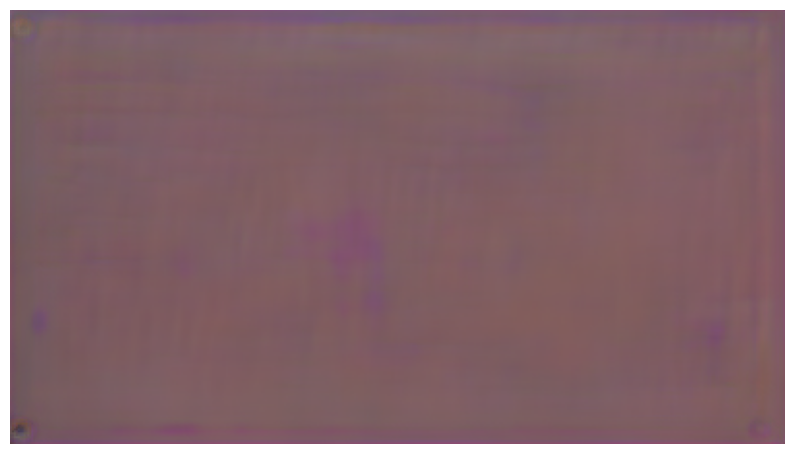

In [19]:
normalize = torchvision.transforms.Normalize(mean = [0.48145466, 0.4578275, 0.40821073], std = [0.26862954, 0.26130258, 0.27577711])
# this part is important because this is related the type of data that has been used to train architecture.
# we have to use these values to normalize data

def encodeText(text):
  t = clip.tokenize(text).cuda()
  # Tokenize the text basically going to take each part of the text prompt represent it with the tokens that
  # are going to be suitable for the model

  t = clipmodel.encode_text(t).detach().clone()
  # we detach the result from the computation of gradients. We'll clone the result so that we use our own memory space and variable
  return t
  # this function gonna take prompt text and is going to produce an encoding through the CLIP architecture

def createEncodings(include, exclude, extras):
  """
  when we want to create our prompts we can specify three things. What to include(elephant dancing in the forest)
  Image move what direction. What to exclude colored ring. Pushing the image not have any colored ring inside.
  Extras fiel some extras to be applied to all the parts of the include. When including we can put multiple things.
  We can put multiple phrases. Elephant, footballers, lady with blue skirt etc... Whatever put extras will apply
  to all of them. Whatever in exclude will also be applied to all of them. We have to encode all of them so this is
  a generic encoding function.

  """
  include_enc = []
  for text in include:
    include_enc.append(encodeText(text)) # accumulate all of these encoders

  exclude_enc = encodeText(exclude) if exclude != "" else 0
  extras_enc = encodeText(extras) if extras != "" else 0
  return include_enc, exclude_enc, extras_enc

  """
  when we are generating our image we are going to be creating also crops of the image and we are going to
  be sending, when we want to basically encode the image to get encoding from clip. We are not going to send
  single image, we are sending a set of crops of the image. Because the more variation we show clip, the better
  we will help clip understand what is the essence of that image. So that it can match it easier and better ways.
  With the encoding of the text.

  We will be doing some augmentations and transformations on our image. Augmentations are first applied to the single
  image produced by the generator. And then from that output the different crops are created

  """

augTransform = torch.nn.Sequential(
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomAffine(30, (0.2, 0.2), fill = 0)
      # Affine transformations, we are gonna do rotation, translation, remains of the picture
      # that are outside of it, we fill it zeros
  ).cuda()

Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img = normalize_data(generator(Params()).cpu()) # 1x3x224x400 [225x400]
  print("img dimensions: ", img.shape)
  show_from_tensor(img[0])
  # it will give us torch.Size([1,256,14,25]) because transformer using patches of 16x16
  # and image with dimensions 1x3x224x400. Not pretty because we are using noise at the moment

# Creating Crops

When we want to encode the image with a CLIP architecture, we want to send not just a single image, number of crops of the image with augmentations, with rotations, so that give us varations of the image to CLIP and help us understand better the essence of that image to match it better with the encoding of the text

In [20]:
def create_crops(img, num_crops = 40):
  # we are gonna add some padding around the image. Because we are gonna do transformations, rotations
  # and we want some extra space around the image so that we can rotate it and preserve the information.

  ps = size1//2 # half of the heigth padding size
  img = torch.nn.functional.pad(img, (ps,ps,ps,ps), mode = 'constant', value = 0) # 1x3x448x624 adding 112 half of heigth on all sides to 224x400
  img = augTransform(img) #random horizontalflip and random affine

  crop_set = [] #accumulate

  for ch in range(num_crops):
    # we want offset the position of the image a little bit take fragment of it , a crop of it
    gap1 = int(torch.normal(1.2, 0.3, ()).clip(0.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())
    """
    we will take normal distribution with certain mean and variance and clip results to control
    them and multiply with heigth and cast int because we want an integer.
    Number of pixels we want to use for offset and also for the amount of crop.
    We are gıing to do same thing but values is different because normal distribution

    A lot of randomness because we want this to be very stochastic because we want all the crops have different
    amounts of offset and cropping etc..
    """

    crop = img[:,:, offsetx: offsetx+gap1, offsety:offsety+gap1]
    # We are taking the crop both on the width and the heigth and also offsetting that crop

    # Now we have to resize these crops to be 224x224. Because CLIP model requires as input a resolution of 224
    crop = torch.nn.functional.interpolate(crop, (224,224), mode = 'bilinear', align_corners = True)
    crop_set.append(crop)

    # After taking all the crops we have to concatenate them. Because we're gonna send them all at once to CLIP
  img_crops = torch.cat(crop_set, dim = 0) #40x3x224x224 40 crops with 3 channels 224 w and 224 h
  randnormal = torch.randn_like(img_crops, requires_grad = False)
  num_rands = 0
  randstotal = torch.rand((img_crops.shape[0], 1, 1, 1)).cuda() #32

  for ns in range(num_rands):
    randtotal *= torch.rand((img_crops.shape[0],1,1,1)).cuda()

  # Because we are interpolating everything we have to add a litt bit of noise

  img_crops = img_crops + noise_factor*randnormal*randstotal
  return img_crops

  """
  In this function we send an image that is the image with data that we are using to generate
  the final result add padding around it so we can apply transformations like rotations. And we generate
  30 different crops with a certain amount of offsetting, cropping. And resize them 224x224 and concatenate
  then add little bit of noise to help of the interpolation making little bit stochastic the process
  and helping the CLIP architecture a little bit more accurate.
  """

# Showing current state of generation

In [21]:
def showme(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented crop exm:")
      aug_gen = generated.float() #1x3x224x400
      aug_gen = create_crops(aug_gen, num_crops = 1)
      aug_gen_norm = normalize_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen = normalize_data(generated.cpu()) #1x3x224x400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

# Optimization

Tweaking parameters that we are gradually changing so that the resulting generated image matches better and better the text prompt.

In [25]:
def optimize_result(Params, prompt):
  alpha = 1 #importance of include encodings
  beta = 0.5 #importance of exclude encodings

  """
  to calculate the loss we will need to compare the encodings of the text prompts wtih the encoding
  of the image crops generated from the current state of our latent space parameters.
  That is why we first need to pass our parameters through the generator to generate an image we can encode.
  """

  #Image encoding
  out = generator(Params())
  out = normalize_data(out)
  out = create_crops(out)
  out = normalize(out) # 40x3x224x224

  """
  We have to do now before we pass this to CLIP, we have to use that normalize that we declared
  before which performs some extra normalization that has to be applied to images too much with
  what clip architecture expecting
  """
  image_enc = clipmodel.encode_image(out) # 30x512
  # CLIP is going to return an encoding that is composed of 512 dimensionality, 512 values

  # Text encoding w1 and w2 weigth of the include text encoding vs the extras text encoding

  final_enc = w1*prompt + w1* extras_enc #prompt and extras: 1x512
  #prompt is current part of the include encoding
  final_text_include_enc = final_enc / final_enc.norm(dim = 1, keepdim = True) #1x512
  # We normalized it for correct range

  final_text_exclude_enc  = exclude_enc

  # Calculate Loss
  main_loss = torch.cosine_similarity(final_text_include_enc, image_enc, -1)
  #40 because take each of 40 crops and compare with single encoding of inc texts
  #cosine similarity is mathematical function that compares to compare vectors

  penalize_loss = torch.cosine_similarity(final_text_exclude_enc, image_enc, -1) #40

  final_loss = -alpha*main_loss + beta*penalize_loss
  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  # we are taking mean because we are gonna get a loss value for each of crops then calculate
  # average
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

# Training Loop

In [26]:
def training_loop(Params, optimizer, show_crop = False):
  res_img = []
  res_z = [] # result latent space
  """
  We are gonna save in them the different images that we generate, and also the different
  sets of parameters as we optimize them. We can use it later to do things like interpolations
  etc...
  """

  for prompt in include_enc:
    """
    for each phrase in the include encodings. For each part of including encodings.
    text may include many different phrases. (Elephant, boy, a girl etc) for each of them
    we will have different encodings so we're gonna go now one by one through these encodings
    """
    iteration = 0
    Params, optimizer, = init_params() #1x256x14x25 (225/16, 400/16)

    for it in range(total_iteration):
      #in the case we're gonna do 200 iterations of evolution of optimization.
      # For each of the text prompts the more you set the more time more memory etc
      loss = optimize(Params, optimizer, prompt)

      if iteration > 0 and iteration%(total_iteration-1)==0:
        #one iteration before the end we are going to display the image
        new_img = showme(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) #1x256x14x25
        print("Loss: ", loss.item(), "\nIteration: ", iteration)

      iteration +=1

    torch.cuda.empty_cache() # delete the cache of the gpu
  return res_img, res_z

  """
  what we do is each of the text and they include set of phrases, we are going to initialize the
  parameters and the optimizer. And then during 200 iterations we are gonna perform an optimization cycle,
  obtaining the loss. And at the end of the process we're gonna display the resulting image.
  """


# Creating

Augmented crop exm:


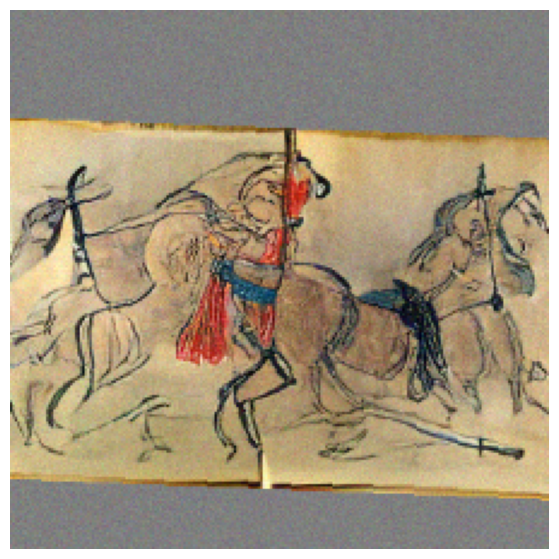

Generation


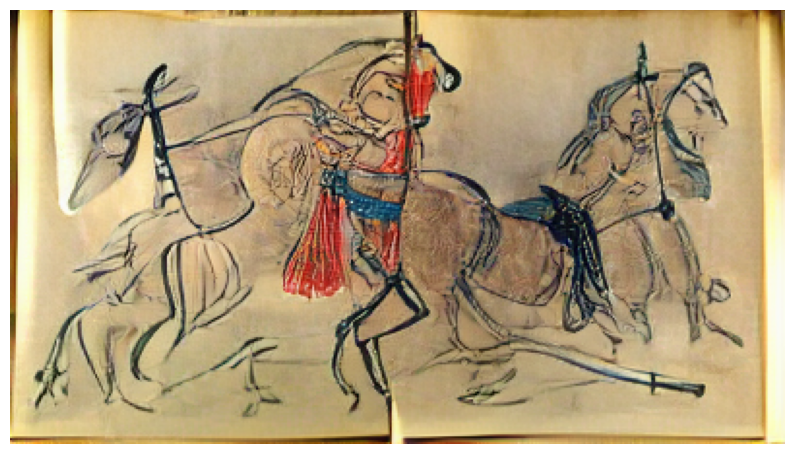

Loss:  -0.2408447265625 
Iteration:  199


In [27]:
torch.cuda.empty_cache()
include = ['sketch of a warrior with a sword on a horse']
exclude = 'watermarks, cropped, incoherrent, cut'
extras = ''
w1 = 1
w2 = 1
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop = True)

In [28]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

1 1
torch.Size([3, 224, 400]) torch.Size([1, 256, 14, 25])
tensor(5.2594, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-5.1858, device='cuda:0', grad_fn=<MinBackward1>)


In [29]:
torch.cuda.empty_cache()
include = ['Two kickboxers fighting in a ring', 'A dragon flies above the volcano']
exclude = 'watermarks, cropped, confusing, incoherrent, cut'
extras = ''
w1 = 1
w2 = 1
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z = training_loop(Params, optimizer, show_crop = True)

Output hidden; open in https://colab.research.google.com to view.

# Interpolation between Points

In [30]:
def interpolate(res_z_list, duration_list):
  gen_img_list = []
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    #we're taking the list of the latent values parameters and list of the durations all together
    #with zip, and enumerating them, going through them 1,2,3,4,5 the number of which we are is going to
    #go an idx and then z, and duration is going to each of the set of latent parameters and each of the durations


    num_steps = int(duration*fps)
    z1 = z #beginning
    z2 = res_z_list[(idx+1)%len(res_z_list)] #end 1x256x14x25
    #this modular is gonna make when you arrive to the last one, is gonna interpolates to the firs one
    #third to the first one again

    for step in range(num_steps):
      #linear interpolation is boring so use math.sin
      alpha = math.sin(1.5*step/num_steps)**6
      #this is gonna produce a value of the interpolation that is basically gonna be faster
      #in the middle and its gonna slow down towards the end.Bigger exponential we put the bigger
      #the contrast between the slowing down of that number as it changes, in comparison previous moments.
      #and creating periodic change in the values as well of the variable
      #we're multiplying 1.5 make sure that at the end of cycle we reach something 0.90 complete
      #full displlay of each of the elements before we move on to the next one


      z_new = alpha*z2+(1-alpha)*z1
      new_gen = normalize_data(generator(z_new).cpu())[0]#3x224x400
      new_image = transforms.ToPILImage(mode = 'RGB')(new_gen)
      gen_img_list.append(new_image)

  return gen_img_list

durations = [4,4,4,4,4,4]
interp_result_img_list = interpolate(res_z, durations)

#ın here we take our set of latent values and our durations. We are going to go through each of them
#and calculate the number of steps that we need for each of them. Then calculate the origin of the interpolation
#and the destination of the interpolation. For number of steps that we need to do we're gonna do non-linear interpolation.
#and each of the new points through interpolation that we calculate we are going to generate a new image.
#we are gonna convert it to a Pillow Image and store it in list.




# Creating a Video from Interpolated Images

In [31]:
out_video_path = f"../result1.mp4"
#video path where we gonna write the video. We are still in the folder of the taming transformers
# so we do ../ to go out of that folder
writer = imageio.get_writer(out_video_path, fps = 25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype = np.uint8)
  #that is what we need to write the values to this MP4 video.
  writer.append_data(img)
  #we append the data to what is being written in the file
writer.close() #close file




In [32]:
#display
from IPython.display import HTML
from base64 import b64encode
mp4 = open(out_video_path,'rb').read()
#we use this path bcs at the beginning we did %cd taming-transformers so all the paths are relative to the contents
#of the taming-transformers folder
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""<video width=800 controls><source src="%s" type = "video/mp4"></video>"""%data_url)

These kind of systems and architectures that we code are very experimental. Results depend on a lot of different parameters, decisions we take. So very important to understand that what to done.
* Change parameters like learning rate, sizes of image etc
* Change creating crops part gap parametersi delete one of the gaps
* Get rid of maybe excludes and extras